In [1]:
%load_ext autoreload
%autoreload 2

from transformers import AutoTokenizer, RobertaConfig,AutoModel
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.optim import lr_scheduler
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from transfer_bert import PhoBert_transform
from model import LSTM_fixed_len
from train import *
from utils import ReviewsDataset
from sklearn.utils import class_weight

In [2]:
phobert = AutoModel.from_pretrained("vinai/phobert-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [3]:
max_length = 25

In [4]:
model = PhoBert_transform(tokenizer,phobert,max_length)

# Load data

In [5]:
data_path = '/home/taindp/Jupyter/intent_bert/data'
model_path = '/home/taindp/Jupyter/intent_bert/model'

In [6]:
question_synth = pd.read_csv(os.path.join(data_path,'train_intent_synth.csv'))
question_rm_sw = pd.read_csv(os.path.join(data_path,'train_intent_rm_sw.csv'))
question = pd.concat([question_synth,question_rm_sw],axis=0)

In [7]:
# question

In [8]:
question['length'] = [len(item) for item in list(question['content'])]
question['num_word'] = [len(item.split(' ')) for item in list(question['content'])]

(array([132., 156.,  68.,  47.,  32.,   9.,   5.,   3.,   4.,   9.]),
 array([  5. ,  16.5,  28. ,  39.5,  51. ,  62.5,  74. ,  85.5,  97. ,
        108.5, 120. ]),
 <BarContainer object of 10 artists>)

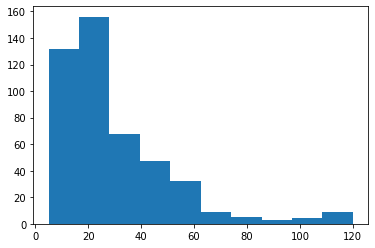

In [9]:
plt.hist(list(question['num_word']), bins = 10)

In [10]:

list_emb_vector = []
for sent in tqdm(list(question['content']),total = len(list(question['content']))):
    input_ids = model.tokenizer_list_sentences([sent], max_length)
    embedding = model.embedding_list_token(input_ids)
    list_emb_vector.append(embedding)
question['emb_vector'] = list_emb_vector
torch.save(question,os.path.join(data_path,'trainset'))

100%|██████████| 465/465 [00:36<00:00, 12.65it/s]


In [11]:
question = torch.load(os.path.join(data_path,'trainset'))

In [12]:
X = list(question['emb_vector'])
y = list(question['label'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

In [13]:
# class_weights = class_weight.compute_class_weight('balanced',np.unique(y).tolist(),y)
# class_weights = torch.tensor(class_weights,dtype=torch.float)

In [14]:
train_ds = ReviewsDataset(X_train, y_train)
valid_ds = ReviewsDataset(X_valid, y_valid)

In [15]:
# for x,y in train_ds:
#     print(y)

In [16]:
batch_size = 1
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)

In [17]:
model_fixed =  LSTM_fixed_len(
                           embedding_dim = 768,\
                           hidden_dim = 100,\
                           num_layers = 2, \
                           bidirectional=True,\
                           dropout=0.5)
model_fixed.cpu()

LSTM_fixed_len(
  (lstm): LSTM(768, 100, num_layers=2, dropout=0.5, bidirectional=True)
  (fc1): Linear(in_features=200, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
  (dropout): Dropout(p=0.5)
)

In [18]:
optimizer = torch.optim.Adam(model_fixed.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [19]:

loss=[]
acc=[]
val_acc=[]
acc_max = 0
for epoch in range(50):
    train_loss, train_acc = train_model(model_fixed,train_dl,optimizer,criterion)
    valid_acc,list_true,list_pred = evaluate (model_fixed, val_dl)
    print('epoch',epoch)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Acc: {valid_acc*100:.2f}%')
    print('='*50)
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)
    
    checkpoint = {'model': model_fixed,
          'state_dict': model_fixed.state_dict(),
          'optimizer' : optimizer.state_dict()}
    if valid_acc > acc_max:
        acc_max = valid_acc
        torch.save(checkpoint, os.path.join(model_path,'checkpoint.pth'))

epoch 0
	Train Loss: 0.673 | Train Acc: 65.59%
	 Val. Acc: 67.74%
epoch 1
	Train Loss: 0.624 | Train Acc: 67.20%
	 Val. Acc: 75.27%
epoch 2
	Train Loss: 0.637 | Train Acc: 67.47%
	 Val. Acc: 75.27%
epoch 3
	Train Loss: 0.648 | Train Acc: 68.01%
	 Val. Acc: 73.12%
epoch 4
	Train Loss: 0.607 | Train Acc: 66.94%
	 Val. Acc: 75.27%
epoch 5
	Train Loss: 0.631 | Train Acc: 66.40%
	 Val. Acc: 79.57%
epoch 6
	Train Loss: 0.577 | Train Acc: 70.16%
	 Val. Acc: 76.34%
epoch 7
	Train Loss: 0.623 | Train Acc: 70.43%
	 Val. Acc: 75.27%
epoch 8
	Train Loss: 0.590 | Train Acc: 69.62%
	 Val. Acc: 73.12%
epoch 9
	Train Loss: 0.547 | Train Acc: 72.58%
	 Val. Acc: 76.34%
epoch 10
	Train Loss: 0.557 | Train Acc: 71.77%
	 Val. Acc: 81.72%
epoch 11
	Train Loss: 0.572 | Train Acc: 73.12%
	 Val. Acc: 76.34%
epoch 12
	Train Loss: 0.531 | Train Acc: 74.46%
	 Val. Acc: 79.57%
epoch 13
	Train Loss: 0.561 | Train Acc: 75.00%
	 Val. Acc: 78.49%
epoch 14
	Train Loss: 0.559 | Train Acc: 73.92%
	 Val. Acc: 74.19%
epoch

# Test

In [20]:
load_model = load_checkpoint(os.path.join(model_path,'checkpoint.pth'))

In [23]:
test_sent = 'có anh chị nào học ngành bảo dưỡng không cho em xin chút ý kiến ạ'
test_input_ids = model.tokenizer_list_sentences([test_sent], max_length)
test_embedding = torch.tensor(model.embedding_list_token(test_input_ids))
test_embedding = test_embedding.type(torch.float32)
test_embedding = torch.reshape(test_embedding,(1,1,768))
preds = load_model(test_embedding)
rounded_preds = torch.round(torch.sigmoid(preds))
rounded_preds

tensor([[1.]])